# Chargement des librairies

In [1]:
suppressMessages(library(sparklyr))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(tableone))
suppressMessages(library(MatchIt))
suppressMessages(library(cobalt))
suppressMessages(library(SuperLearner))
suppressMessages(library(gam))
suppressMessages(library(drtmle))
suppressMessages(library(WeightIt))
suppressMessages(library(marginaleffects))
suppressMessages(library(sandwich))
suppressMessages(library(boot))
suppressMessages(library(moderndive))
suppressMessages(library(glmm))
suppressMessages(library(car))
suppressMessages(library(fastDummies))

Warning message:
“Failed to locate timezone database”


# Connexion à Spark

In [2]:
config <- spark_config()
sc <- spark_connect(master = "yarn-cluster", config = config, version = '2.4.3')

# Chargement des tables de data_management

In [3]:
tbl_change_db(sc, 'cse_200007_work')

spark_read_parquet(sc, 'sejours_rea_48_heures', 'sejours_rea_48_heures')

# Source: spark<sejours_rea_48_heures> [?? x 139]
   encounter_num        location_cd chads_vasc patient_num   start_date_stay    
   <chr>                <chr>            <dbl> <chr>         <dttm>             
 1 5347953158377635787  UFR:005389           0 -38338136620… 2017-09-18 19:51:00
 2 3586793873509562842  UFR:014025           2 -61229049708… 2013-03-02 13:21:00
 3 -5427721102107319419 UFR:005389           1 -64002042299… 2019-10-17 15:10:00
 4 5361008629094847616  UFR:010260           4 -67959312721… 2018-06-17 17:56:00
 5 449789647902201406   UFR:026151           3 -68408060972… 2018-06-16 14:04:00
 6 -7771031489852610941 UFR:026513           2 240530890957… 2019-10-11 16:19:00
 7 -7884841415759866314 UFR:047242           1 269950297489… 2020-01-03 13:49:00
 8 7615374549036810729  UFR:026513           3 285107867839… 2019-02-25 16:55:00
 9 -4817202570237703233 UFR:011440           5 382933761814… 2018-08-02 05:36:00
10 -1613539001290686381 UFR:087260           2 386166178502

In [4]:
sejours_rea_48_heures <- sc %>% tbl('sejours_rea_48_heures')

## Ajout de variables dans la table des séjours

In [5]:
sejours_rea_48_heures <- sejours_rea_48_heures %>%
    mutate(hemorragie = ifelse(hemorragie_respiratoire == 1 | hemorragie_cerebrale == 1 | hemorragie_digestif == 1 | hemorragie_autre == 1 | hemorragie_iatrogene == 1 | hemorragie_articulaire == 1, 1, 0)) %>%
    mutate(hbpm_efficacite_anticoag_binary = ifelse(hbpm_efficacite_anticoag == "efficace", 1, 0)) %>%
    mutate(hnf_efficacite_anticoag_binary = ifelse(hnf_efficacite_anticoag == "efficace", 1, 0)) %>%
    mutate(efficacite_anticoag_binary = ifelse(hnf_efficacite_anticoag_binary == 1 | hbpm_efficacite_anticoag_binary == 1, 1,0)) %>%
    mutate(etat_choc = ifelse(choc_septique == 1 | choc_cardiogenique == 1 | choc_hypovolemique == 1 | choc_autre == 1, 1, 0)) %>%
    mutate(surdosage = ifelse(hnf_surdosage == 1 | hbpm_surdosage == 1, 1, 0)) %>%
    na.replace(surdosage = 0) %>%
    na.replace(efficacite_anticoag_binary = 0) %>%
    na.replace(diag_cat = "Inconnu") %>%
    mutate(annee=year(start_date_stay)) %>%
    collect() %>%
    mutate(location_cd=as_factor(location_cd)) %>%
    mutate(diag_cat=as_factor(diag_cat)) %>%
    dummy_cols(., select_columns = "diag_cat")

# Tables 1
## Définition des variables

In [6]:
var_patients <- c('age_at_stay_entry', 'duree_sejour', 'duree_visite', 'sex_cd', 'death_during_stay', 'death_during_visit', 'type_rea',
                  'atcd_hta', 'atcd_diabete', 'atcd_obesite', 'atcd_bpco', 'atcd_ins_cardiaque', 'atcd_ins_renale', 
                  'diag_cat', 'chads_vasc', 'fadenovo', 'volonte_anticoag',
                  'vm', 'vasopresseurs', 'eer', 'coagulopathie', 'volonte_anticoag', 
                  'choc_septique', 'choc_autre', 'choc_hypovolemique',
                  'hnf_mediane', 'hbpm_mediane', 'hnf_efficacite_anticoag', 'hbpm_efficacite_anticoag', 'choc_cardiogenique',
                  'ischemie_cerebrale', 'ischemie_splenique', 'ischemie_renal',
                  'hemorragie', 'hemorragie_urinaire', 'hemorragie_respiratoire', 'hemorragie_cerebrale', 'hemorragie_digestif', 'hemorragie_autre', 'hemorragie_iatrogene', 'hemorragie_articulaire')

cat_Vars <- c('sex_cd', 'death_during_stay', 'death_during_visit', 'type_rea', 'fadenovo', 'volonte_anticoag',
              'diag_cat',
              'atcd_hta', 'atcd_diabete', 'atcd_obesite', 'atcd_bpco', 'atcd_ins_cardiaque', 'atcd_ins_renale',
              'vm', 'vasopresseurs', 'eer', 'coagulopathie',
              'hnf_efficacite_anticoag', 'hbpm_efficacite_anticoag',
              'choc_cardiogenique', 'choc_septique', 'choc_autre', 'choc_hypovolemique',
              'ischemie_cerebrale', 'ischemie_splenique', 'ischemie_renal',
              'hemorragie','hemorragie_urinaire','hemorragie_respiratoire', 'hemorragie_cerebrale', 'hemorragie_digestif', 'hemorragie_autre', 'hemorragie_iatrogene', 'hemorragie_articulaire')

## Table 1 sur l'ensemble des patients

In [7]:
tableone <- CreateTableOne(data = collect(sejours_rea_48_heures), factorVars = cat_Vars, vars = var_patients )

tableone

# summary(tableone)

                                 
                                  Overall      
  n                                4962        
  age_at_stay_entry (mean (SD))   73.40 (11.01)
  duree_sejour (mean (SD))         7.24 (8.13) 
  duree_visite (mean (SD))        27.42 (26.26)
  sex_cd = W (%)                   1710 (34.5) 
  death_during_stay = 1 (%)         529 (10.7) 
  death_during_visit (%)                       
     0                             3894 (78.5) 
     1                             1062 (21.4) 
     NaN                              6 ( 0.1) 
  type_rea = med (%)               3702 (74.6) 
  atcd_hta = 1 (%)                 2043 (41.2) 
  atcd_diabete = 1 (%)             1069 (21.5) 
  atcd_obesite = 1 (%)              556 (11.2) 
  atcd_bpco = 1 (%)                 605 (12.2) 
  atcd_ins_cardiaque = 1 (%)       1133 (22.8) 
  atcd_ins_renale = 1 (%)           752 (15.2) 
  diag_cat (%)                                 
     Post_op                        544 (11.0) 
     I

## Table 1 stratifiée sur le décès pendant le séjour

In [8]:
tabletwo <- CreateTableOne(data = collect(sejours_rea_48_heures), factorVars = cat_Vars, vars = var_patients, strata = 'death_during_stay')

tabletwo

# summary(tabletwo)

                                 Stratified by death_during_stay
                                  0             1              p      test
  n                                4433           529                     
  age_at_stay_entry (mean (SD))   73.17 (11.03) 75.26 (10.65)   NA        
  duree_sejour (mean (SD))         6.87 (7.74)  10.34 (10.40)   NA        
  duree_visite (mean (SD))        28.75 (27.03) 16.30 (14.45)   NA        
  sex_cd = W (%)                   1510 (34.1)    200 ( 37.8)   0.096     
  death_during_stay = 1 (%)           0 ( 0.0)    529 (100.0)  <0.001     
  death_during_visit (%)                                       <0.001     
     0                             3894 (87.8)      0 (  0.0)             
     1                              534 (12.0)    528 ( 99.8)             
     NaN                              5 ( 0.1)      1 (  0.2)             
  type_rea = med (%)               3268 (73.7)    434 ( 82.0)  <0.001     
  atcd_hta = 1 (%)                 

## Table 1 stratifiée sur l'exposition à l'anticoagulation

In [9]:
tablethree <- CreateTableOne(data = collect(sejours_rea_48_heures), factorVars = cat_Vars, vars = var_patients, addOverall = TRUE, strata = 'volonte_anticoag')

tablethree

# summary(tablethree)

                                 Stratified by volonte_anticoag
                                  Overall       0              1             
  n                                4962          3678           1284         
  age_at_stay_entry (mean (SD))   73.40 (11.01) 73.55 (11.01)  72.94 (10.99) 
  duree_sejour (mean (SD))         7.24 (8.13)   6.75 (7.77)    8.67 (8.93)  
  duree_visite (mean (SD))        27.42 (26.26) 26.76 (26.95)  29.32 (24.09) 
  sex_cd = W (%)                   1710 (34.5)   1253 ( 34.1)    457 ( 35.6) 
  death_during_stay = 1 (%)         529 (10.7)    372 ( 10.1)    157 ( 12.2) 
  death_during_visit (%)                                                     
     0                             3894 (78.5)   2924 ( 79.5)    970 ( 75.5) 
     1                             1062 (21.4)    752 ( 20.4)    310 ( 24.1) 
     NaN                              6 ( 0.1)      2 (  0.1)      4 (  0.3) 
  type_rea = med (%)               3702 (74.6)   2698 ( 73.4)   1004 ( 78.2) 


## Table 1 stratifiée sur l'ischémie cérébrale

In [10]:
tablefour <- CreateTableOne(data = collect(sejours_rea_48_heures), factorVars = cat_Vars, vars = var_patients, strata = 'ischemie_cerebrale')
tablefour

# summary(tablefour)

                                 Stratified by ischemie_cerebrale
                                  0             1              p      test
  n                                4857           105                     
  age_at_stay_entry (mean (SD))   73.39 (11.03) 73.52 (9.84)    NA        
  duree_sejour (mean (SD))         7.18 (8.06)  10.31 (10.50)   NA        
  duree_visite (mean (SD))        27.08 (25.48) 43.09 (48.10)   NA        
  sex_cd = W (%)                   1672 (34.4)     38 ( 36.2)   0.785     
  death_during_stay = 1 (%)         517 (10.6)     12 ( 11.4)   0.922     
  death_during_visit (%)                                        0.184     
     0                             3819 (78.6)     75 ( 71.4)             
     1                             1032 (21.2)     30 ( 28.6)             
     NaN                              6 ( 0.1)      0 (  0.0)             
  type_rea = med (%)               3625 (74.6)     77 ( 73.3)   0.849     
  atcd_hta = 1 (%)                

# Modélisation statistique

## Sommaire des variables d'intérêt

In [11]:
sejours_rea_48_heures %>%
    select(c('sex_cd','age_at_stay_entry','vasopresseurs','eer', 'diag_cat', 'chads_vasc','vm','atcd_hta','atcd_bpco','atcd_diabete','atcd_ins_cardiaque','atcd_ins_renale',
             'atcd_obesite','annee','type_rea', 'fadenovo', 'etat_choc', 'surdosage', 'volonte_anticoag', 'location_cd')) %>%
    as_tibble() %>%
    summary()

    sex_cd          age_at_stay_entry vasopresseurs        eer         
 Length:4962        Min.   : 23.0     Min.   :0.000   Min.   :0.00000  
 Class :character   1st Qu.: 67.0     1st Qu.:0.000   1st Qu.:0.00000  
 Mode  :character   Median : 74.0     Median :0.000   Median :0.00000  
                    Mean   : 73.4     Mean   :0.339   Mean   :0.09815  
                    3rd Qu.: 81.0     3rd Qu.:1.000   3rd Qu.:0.00000  
                    Max.   :101.0     Max.   :1.000   Max.   :1.00000  
                                                                       
    diag_cat      chads_vasc          vm            atcd_hta     
 Autre  :1185   Min.   :0.000   Min.   :0.0000   Min.   :0.0000  
 Inconnu: 799   1st Qu.:1.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Cardio : 729   Median :2.000   Median :0.0000   Median :0.0000  
 Respi  : 648   Mean   :2.236   Mean   :0.3132   Mean   :0.4117  
 Post_op: 544   3rd Qu.:3.000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Sepsis : 458   Max.   :7.00

## Estimation d'un score de propension, avec pondération inverse. 

In [12]:
W_PS <- weightit(volonte_anticoag ~ sex_cd + age_at_stay_entry + vasopresseurs + eer + diag_cat + chads_vasc + vm + atcd_hta + atcd_bpco + 
              atcd_diabete + atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + fadenovo + etat_choc, 
              data = collect(sejours_rea_48_heures), 
              method = "glm", 
              estimand = "ATE")

In [13]:
W_PS

A weightit object
 - method: "glm" (propensity score weighting with GLM)
 - number of obs.: 4962
 - sampling weights: none
 - treatment: 2-category
 - estimand: ATE
 - covariates: sex_cd, age_at_stay_entry, vasopresseurs, eer, diag_cat, chads_vasc, vm, atcd_hta, atcd_bpco, atcd_diabete, atcd_ins_cardiaque, atcd_ins_renale, atcd_obesite, annee, type_rea, fadenovo, etat_choc

### Ajout des poids à la table des séjours

In [14]:
sejours_rea_48_heures$weights <- W_PS$weights

### Table des corrections des covariables par le score de propension

In [15]:
bal.tab(W_PS, un = TRUE)

Balance Measures
                                Type Diff.Un Diff.Adj
prop.score                  Distance  0.5883   0.0035
sex_cd_W                      Binary  0.0152   0.0020
age_at_stay_entry            Contin. -0.0560   0.0100
vasopresseurs                 Binary  0.1920  -0.0033
eer                           Binary  0.0872   0.0009
diag_cat_Post_op              Binary -0.0344  -0.0059
diag_cat_Inconnu              Binary -0.0323   0.0019
diag_cat_Autre                Binary  0.0035  -0.0005
diag_cat_Cardio               Binary  0.0655   0.0009
diag_cat_Sepsis               Binary  0.0142  -0.0019
diag_cat_Respi                Binary  0.0066   0.0036
diag_cat_Metabo               Binary  0.0103  -0.0007
diag_cat_Neuro                Binary -0.0169  -0.0007
diag_cat_Hemato               Binary -0.0025   0.0025
diag_cat_Trauma_non_cranien   Binary -0.0117  -0.0003
diag_cat_Hepatique            Binary -0.0022   0.0011
chads_vasc                   Contin.  0.0925   0.0221
vm         

### Graphique des corrections des covariables par le score de propension

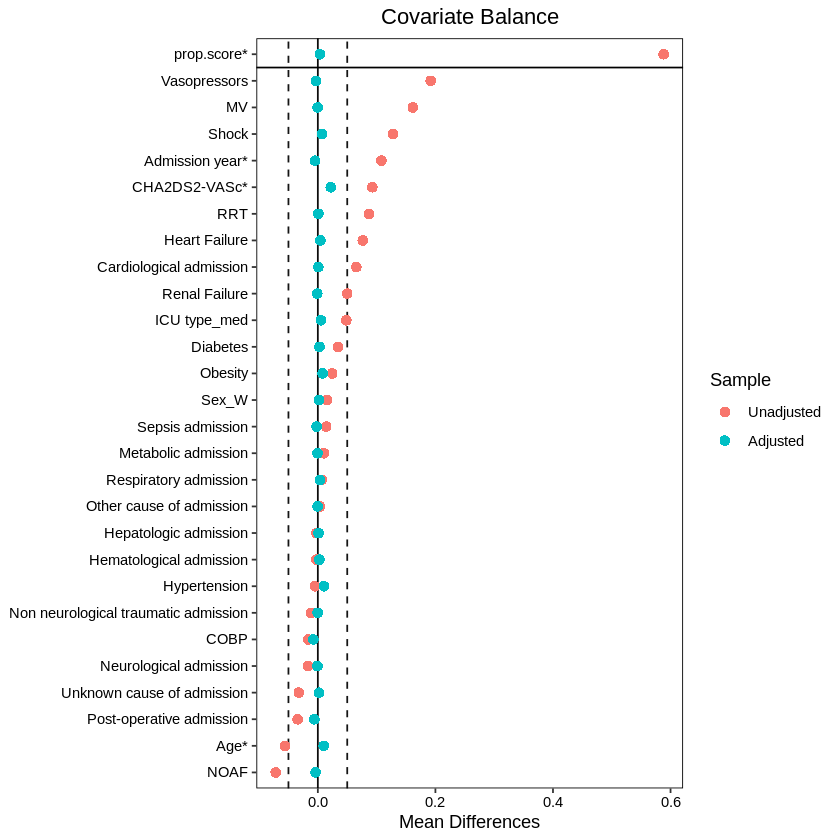

In [16]:
v_love_plot <- data.frame(old = c('sex_cd','age_at_stay_entry','vasopresseurs','eer',
                                  'diag_cat_Post_op','diag_cat_Inconnu','diag_cat_Autre','diag_cat_Cardio','diag_cat_Sepsis','diag_cat_Respi',
                                  'diag_cat_Metabo','diag_cat_Neuro','diag_cat_Hemato','diag_cat_Trauma_non_cranien','diag_cat_Hepatique',
                                  'chads_vasc','vm','atcd_hta','atcd_bpco','atcd_diabete','atcd_ins_cardiaque','atcd_ins_renale','atcd_obesite',
                                  'annee','type_rea', 'fadenovo', 'etat_choc'),
                          new = c('Sex','Age','Vasopressors','RRT',
                                  'Post-operative admission','Unknown cause of admission','Other cause of admission','Cardiological admission','Sepsis admission','Respiratory admission',
                                  'Metabolic admission','Neurological admission','Hematological admission','Non neurological traumatic admission','Hepatologic admission',
                                  'CHA2DS2-VASc','MV','Hypertension','COBP','Diabetes','Heart Failure','Renal Failure',
             'Obesity','Admission year','ICU type', 'NOAF', 'Shock'))

love.plot(W_PS, stars = 'std', threshold = .05, var.order = "unadjusted", var.names = v_love_plot)

### Graphique des poids du score de propension selon les groupes d'anticoagulation

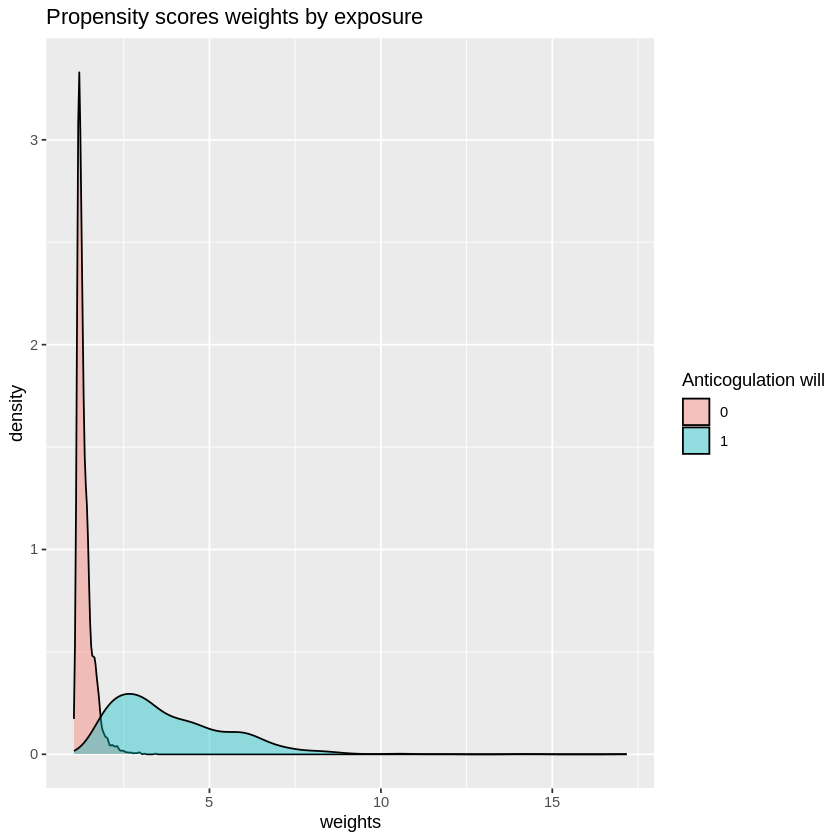

In [17]:
sejours_rea_48_heures %>%
    ggplot(aes(x = weights, fill = as_factor(volonte_anticoag))) +
    geom_density(alpha = 0.4) +
    labs(title = "Propensity scores weights by exposure",
         fill = "Anticogulation will")

### Sommaire des poids inversés

In [18]:
summary(W_PS)

                 Summary of weights

- Weight ranges:

           Min                                   Max
treated 1.4594  |--------------------------| 17.1693
control 1.0461 |--|                           3.4222

- Units with the 5 most extreme weights by group:
                                               
           3059    3950    2906    2819    3531
 treated 10.679 11.8618 14.0055 14.5171 17.1693
            690      63    2610     465    3370
 control 2.9538  2.9591  2.9604  3.1042  3.4222

- Weight statistics:

        Coef of Var   MAD Entropy # Zeros
treated       0.450 0.354   0.092       0
control       0.177 0.125   0.014       0

- Effective Sample Sizes:

           Control Treated
Unweighted 3678.   1284.  
Weighted   3566.44 1068.15

## Modèle de l'outcome avec l'estimateur double-robuste proposé par le package DRTMLE
### Régression par GLM 

In [19]:
set.seed(100384)
W_GLM <- collect(sejours_rea_48_heures %>% select(c('ischemie_cerebrale','volonte_anticoag','sex_cd','age_at_stay_entry','vasopresseurs','eer','chads_vasc','vm',
                                        'atcd_hta','atcd_bpco','atcd_diabete','atcd_ins_cardiaque','atcd_ins_renale','atcd_obesite','annee','type_rea',
                                        'etat_choc','fadenovo', 'diag_cat')))
A <- collect(sejours_rea_48_heures %>% select(volonte_anticoag)) %>% unlist() %>% as.integer()
Y <- collect(sejours_rea_48_heures %>% select(ischemie_cerebrale)) %>% unlist() %>% as.integer()

In [20]:
glm_fit_uni <- drtmle(W = W_GLM, A = A, Y = Y, family = binomial(),
                      glm_g = "sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat", 
                      glm_Q = "(sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat)*A",
                      glm_gr = "Qn", glm_Qr = "gn", stratify = FALSE)

glm_fit_uni

$est
            
0 0.02032958
1 0.02383547

$cov
             0            1
0 5.754253e-06 5.622766e-08
1 5.622766e-08 2.279969e-05


In [21]:
ci(glm_fit_uni)

$drtmle
    est   cil   ciu
0 0.020 0.016 0.025
1 0.024 0.014 0.033


In [22]:
riskRatio <- list(f = function(eff) {log(eff)},
                  f_inv = function(eff) {exp(eff)},
                  h = function(est) {est[2]/est[1]},
                  fh_grad = function(est){c(1/est[2],-1/est[1])})

In [23]:
ci(glm_fit_uni, contrast = riskRatio)

$drtmle
                est   cil   ciu
user contrast 1.172 0.711 1.933


### Régression par SuperLearner

W_SL enlève ischemie cerebrale, volonte d'anticoagulation et catégorie diagnostique car :
 - le modèle de SL intègre l'ensemble des variables du tableau et rend l'erreur "glm.fit : algorithm did not converge" car ces variables sont l'exposition et l'outcome)
 - le modèle Gam n'accepte pas les variables catégorielles à plusieurs facteurs mais uniquement les variables binaires, d'où le retrait de diag_cat et son remplacement par des dummy variables (on aurait aussi pu faire un pivot_wider)

In [24]:
W_SL <- W_GLM %>% select(-c('ischemie_cerebrale', 'volonte_anticoag', 'diag_cat'))

In [25]:
sl_fit <- drtmle(W = W_SL, A = A, Y = Y, family = binomial(),
                 SL_g = c("SL.glm","SL.mean", "SL.step.forward", "SL.gam", "SL.stepAIC", "SL.randomForest"),
                 SL_Q = c("SL.glm","SL.mean", "SL.step.forward", "SL.gam", "SL.stepAIC", "SL.randomForest"),
                 SL_gr = c("SL.glm","SL.mean", "SL.step.forward", "SL.gam", "SL.stepAIC", "SL.randomForest"),
                 SL_Qr = c("SL.glm","SL.mean", "SL.step.forward", "SL.gam", "SL.stepAIC", "SL.randomForest"),
                 stratify = FALSE)
sl_fit

Loading required package: nloptr

Loading required namespace: randomForest

Loading required package: quadprog



$est
            
0 0.02056279
1 0.02179988

$cov
             0            1
0 5.791292e-06 9.622318e-08
1 9.622318e-08 1.793895e-05


In [26]:
ci(sl_fit)

$drtmle
    est   cil   ciu
0 0.021 0.016 0.025
1 0.022 0.013 0.030


In [27]:
riskRatio <- list(f = function(eff) {log(eff)},
                  f_inv = function(eff) {exp(eff)},
                  h = function(est) {est[2]/est[1]},
                  fh_grad = function(est){c(1/est[2],-1/est[1])})

In [28]:
ci(sl_fit, contrast = riskRatio)

$drtmle
               est   cil   ciu
user contrast 1.06 0.672 1.673


## Estimateur double robuste AIPTW fait main

In [29]:
fit <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat, 
           data = collect(sejours_rea_48_heures), family = 'quasibinomial')

In [30]:
sejours_rea_48_heures_T1 <- sejours_rea_48_heures
sejours_rea_48_heures_T1$volonte_anticoag <- 1
mu1_hat <- predict(fit, newdata = sejours_rea_48_heures_T1, type = "response")

In [31]:
sejours_rea_48_heures_T0 <- sejours_rea_48_heures
sejours_rea_48_heures_T0$volonte_anticoag <- 0
mu0_hat <- predict(fit, newdata = sejours_rea_48_heures_T0, type = "response")

ps_hat <- W_PS$ps

aiptw_1 <- (sejours_rea_48_heures$volonte_anticoag * (sejours_rea_48_heures$ischemie_cerebrale - mu1_hat) / ps_hat) + mu1_hat
aiptw_0 <- ((1 - sejours_rea_48_heures$volonte_anticoag) * (sejours_rea_48_heures$ischemie_cerebrale - mu0_hat) / (1 - ps_hat)) + mu0_hat

aiptw_diff <- aiptw_1 - aiptw_0
ATE_hat <- mean(aiptw_diff)

se_ATE <- as.numeric(sd(aiptw_diff) /sqrt(count(sejours_rea_48_heures)))

CI_lower <- ATE_hat - 1.96 * se_ATE
CI_upper <- ATE_hat + 1.96 * se_ATE

cat("ATE (AIPTW) :", round(ATE_hat, 4), "\n")
cat("IC 95% : [", round(CI_lower, 4), ",", round(CI_upper, 4), "]\n")

ATE (AIPTW) : 0.0027 
IC 95% : [ -0.008 , 0.0133 ]


In [32]:
RR <- mean(aiptw_1) / mean(aiptw_0)
se_p1 <- as.numeric(sd(aiptw_1) / sqrt(count(sejours_rea_48_heures)))
se_p0 <- as.numeric(sd(aiptw_0) / sqrt(count(sejours_rea_48_heures)))
se_logRR <- sqrt((se_p1 / mean(aiptw_1))^2 + (se_p0 / mean(aiptw_0))^2)
logRR <- log(RR)
CI_logRR <- c(logRR - 1.96 * se_logRR, logRR + 1.96 * se_logRR)
CI_RR <- exp(CI_logRR)

cat("Risk Ratio :", round(RR, 3), "\n")
cat("IC 95% : [", round(CI_RR[1], 3), ",", round(CI_RR[2], 3), "]\n")

Risk Ratio : 1.131 
IC 95% : [ 0.702 , 1.822 ]


## Modèle classique de régression logistique

 - En intégrant les covariables du score de propension et d'autres reliées à la survenue d'une ischémie cérébrale.
 - Equations de G-computation pour l'estimation de l'Average Treatmen Effect (ATE)

In [33]:
fit <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat, 
           data = collect(sejours_rea_48_heures), family = 'quasibinomial', weights = sejours_rea_48_heures$weights)

In [34]:
avg_comparisons(fit, variables = "volonte_anticoag",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures),
                wts = sejours_rea_48_heures$weights,
                comparison = "lnratioavg",
                transform = "exp")

term,contrast,estimate,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
volonte_anticoag,ln(mean(1) / mean(0)),1.121775,0.6367331,0.6512393,0.6962936,1.807255,0.01930818,0.02175199,0.01930818


In [35]:
avg_comparisons(fit, variables = "volonte_anticoag",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures),
                wts = sejours_rea_48_heures$weights)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
volonte_anticoag,1 - 0,0.002499325,0.005472761,0.4566845,0.6478978,0.6261618,-0.008227088,0.01322574


### Estimation de l'ATE et des paramètres associés par bootstrap
Erreur standard, intervalle de confiance

#### Fonction à itérer avec les deux modèles 
(SP avec poids inverses et régression logistique avec ischémie cérébrale)

In [36]:
boot_fun <- function(data, i) {
  boot_data <- data[i,]
  
  #PS weighting for the ATE
  W <- weightit(volonte_anticoag ~ sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo,
              data = boot_data, 
              method = "glm", 
              estimand = "ATE")
  
  #Bring weights into the dataset
  boot_data$weights <- W_PS$weights
  
  #Fit outcome model
  fit <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + 
                                                      atcd_diabete + atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo,
             data = boot_data, weights = boot_data$weights,
             family = 'quasibinomial')
  
  #G-computation
  comp <- avg_comparisons(fit,
                          variables = 'volonte_anticoag',
                          vcov = FALSE,
                          newdata = boot_data,
                          wts = boot_data$weights,
                          comparison = "lnratioavg",
                          transform = "exp")
  
  comp$estimate
}

#### Bootstrap
5000 itérations
##### RR, biais, erreur standard

In [37]:
set.seed(100384)

boot_out <- boot(collect(sejours_rea_48_heures), boot_fun, R = 5000)

boot_out


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = collect(sejours_rea_48_heures), statistic = boot_fun, 
    R = 5000)


Bootstrap Statistics :
    original      bias    std. error
t1* 1.126076 -0.03539642   0.2783053

#### Intervalles de confiance

In [38]:
boot.ci(boot_out, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 5000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_out, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.623,  1.691 )  
Calculations and Intervals on Original Scale

#### Représentation graphique

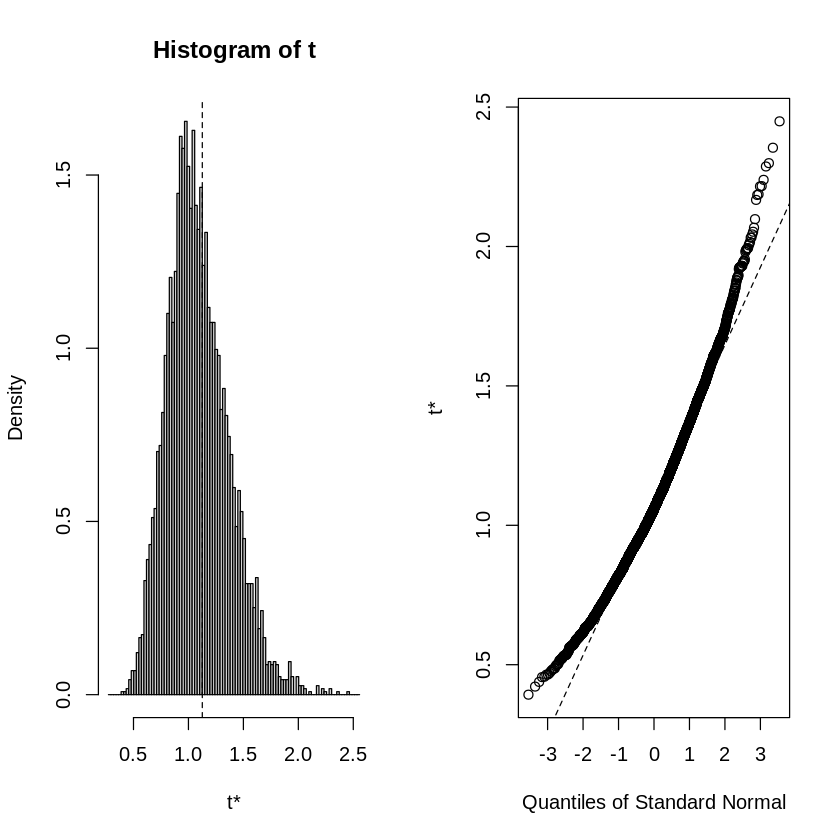

In [39]:
plot(boot_out)

## Vérification des hypothèses du modèle
### Distribution normale des variables continues
#### Âge

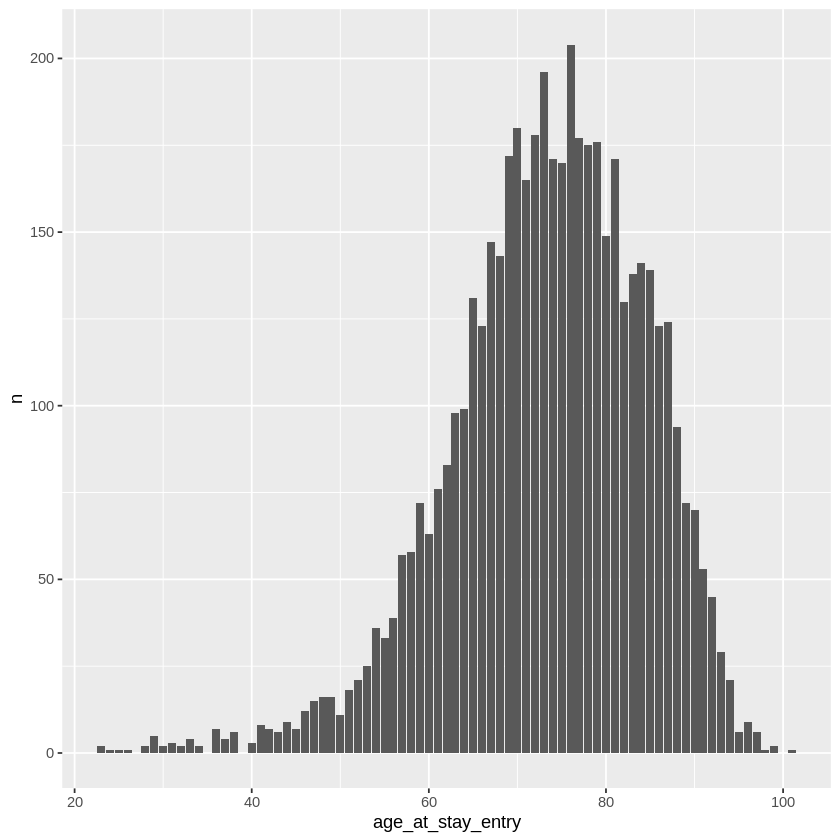

In [40]:
sejours_rea_48_heures %>%
    count(age_at_stay_entry) %>%
    ggplot + geom_col(aes(x = age_at_stay_entry, y = n))

#### Score CHADS-VASC

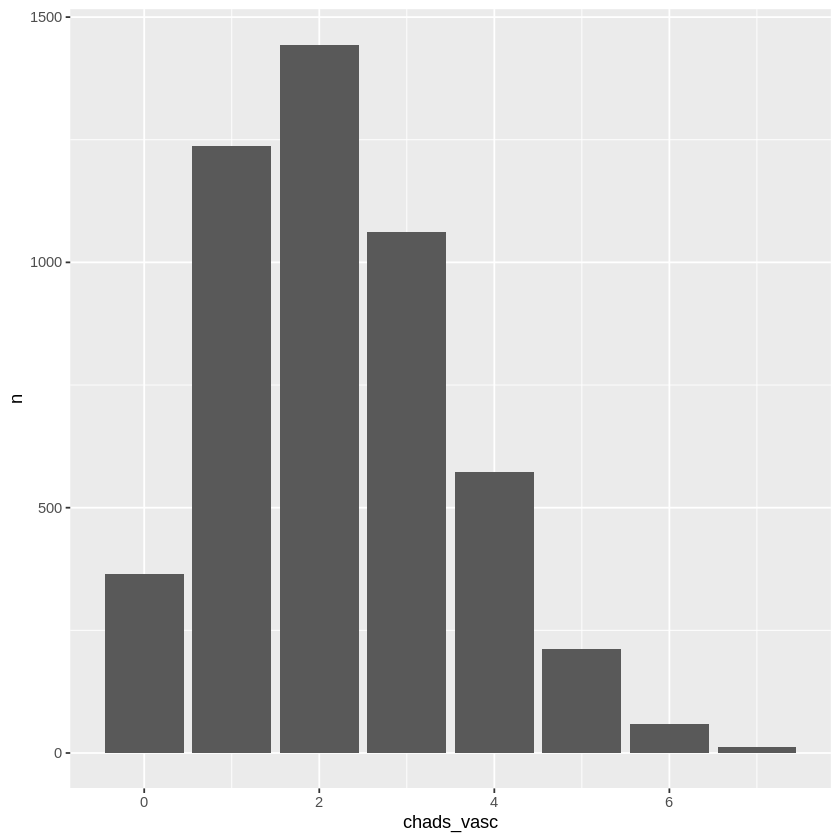

In [41]:
sejours_rea_48_heures %>%
    count(chads_vasc) %>%
    ggplot + geom_col(aes(x = chads_vasc, y = n))

### Non-multicolinéarité du modèle d'outcome
Fit est le modèle GLM standard  
A priori VIF doit rester inférieur à 5

In [42]:
vif(fit)

,GVIF,Df,GVIF^(1/(2*Df))
volonte_anticoag,1.012934,1,1.006446
sex_cd,1.378765,1,1.174208
age_at_stay_entry,1.414259,1,1.189226
vasopresseurs,2.044726,1,1.429939
eer,1.191322,1,1.091477
chads_vasc,4.203158,1,2.050161
vm,1.665108,1,1.290391
atcd_hta,1.860646,1,1.364055
atcd_bpco,1.052536,1,1.025932
atcd_diabete,1.644592,1,1.282416


### Examen des paramètres de l'estimateur TMLE (package DRTMLE)

In [43]:
summary(glm_fit_uni)

                 Length Class  Mode   
drtmle            2     -none- list   
nuisance_drtmle   5     -none- list   
ic_drtmle         4     -none- list   
aiptw_c           2     -none- list   
nuisance_aiptw_c  4     -none- list   
tmle              2     -none- list   
aiptw             2     -none- list   
gcomp             2     -none- list   
QnMod             0     -none- NULL   
gnMod             0     -none- NULL   
QrnMod            0     -none- NULL   
grnMod            0     -none- NULL   
a_0               2     -none- numeric
call             10     -none- call   

In [44]:
IC <- glm_fit_uni$ic_drtmle

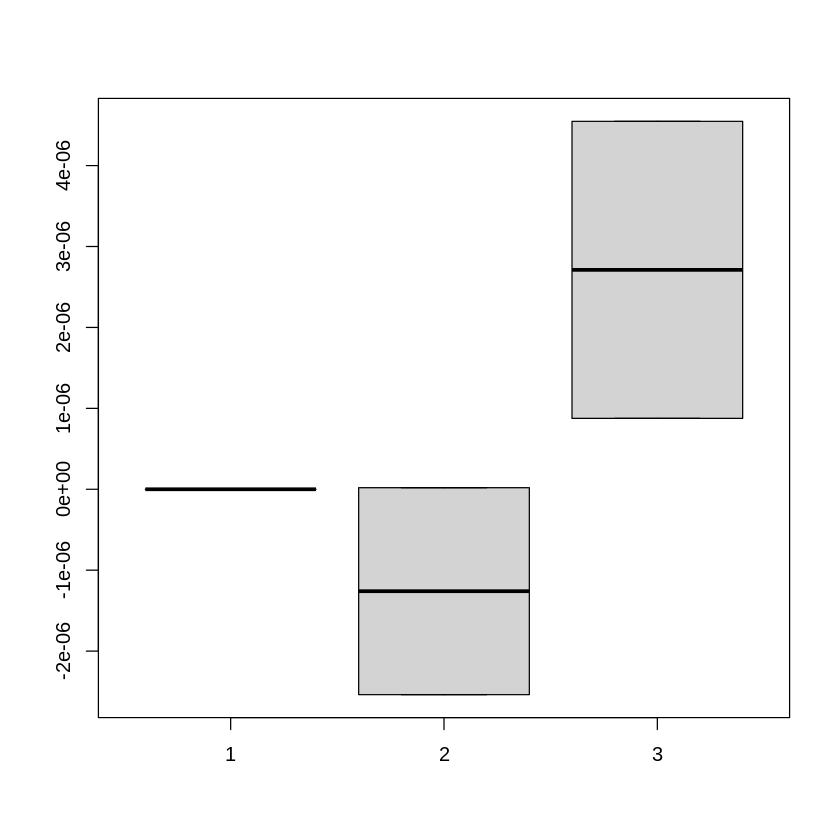

In [45]:
boxplot(IC$mean_eif, IC$mean_missQ, IC$mean_missg)

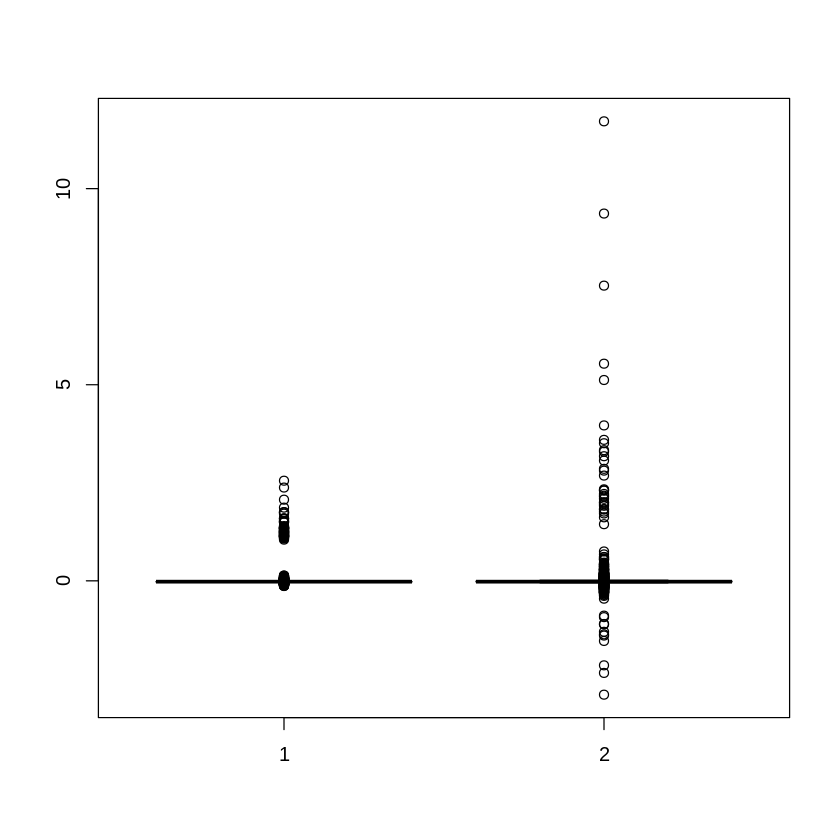

In [46]:
boxplot(IC$ic)

# Analyses secondaires

## Estimateur double robuste pour évaluer le risque hémorragique associé à l'anticoagulation (DRTMLE)
### Toutes hémorragies

In [47]:
Y_h <- collect(sejours_rea_48_heures %>% select(hemorragie)) %>% unlist() %>% as.integer()

In [48]:
glm_fit_uni <- drtmle(W = W_GLM, A = A, Y = Y_h, family = binomial(),
                      glm_g = "sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat", 
                      glm_Q = "(sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat)*A",
                      glm_gr = "Qn", glm_Qr = "gn", stratify = FALSE)

glm_fit_uni

$est
            
0 0.08184872
1 0.08007433

$cov
             0            1
0 2.150542e-05 7.368316e-07
1 7.368316e-07 6.206910e-05


In [49]:
ci(glm_fit_uni)

$drtmle
    est   cil   ciu
0 0.082 0.073 0.091
1 0.080 0.065 0.096


In [50]:
riskRatio <- list(f = function(eff) {log(eff)},
                  f_inv = function(eff) {exp(eff)},
                  h = function(est) {est[2]/est[1]},
                  fh_grad = function(est){c(1/est[2],-1/est[1])})

In [51]:
ci(glm_fit_uni, contrast = riskRatio)

$drtmle
                est   cil   ciu
user contrast 0.978 0.787 1.217


### Hémorragies iatrogènes

In [52]:
Y_h_i <- collect(sejours_rea_48_heures %>% select(hemorragie_iatrogene)) %>% unlist() %>% as.integer()

In [53]:
glm_fit_uni <- drtmle(W = W_GLM, A = A, Y = Y_h_i, family = binomial(),
                      glm_g = "sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat", 
                      glm_Q = "(sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat)*A",
                      glm_gr = "Qn", glm_Qr = "gn", stratify = FALSE)

glm_fit_uni

$est
            
0 0.02634594
1 0.04915215

$cov
             0            1
0 7.244554e-06 4.165454e-07
1 4.165454e-07 4.099701e-05


In [54]:
ci(glm_fit_uni)

$drtmle
    est   cil   ciu
0 0.026 0.021 0.032
1 0.049 0.037 0.062


In [55]:
riskRatio <- list(f = function(eff) {log(eff)},
                  f_inv = function(eff) {exp(eff)},
                  h = function(est) {est[2]/est[1]},
                  fh_grad = function(est){c(1/est[2],-1/est[1])})

In [56]:
ci(glm_fit_uni, contrast = riskRatio)

$drtmle
                est   cil   ciu
user contrast 1.866 1.148 3.032


### Hémorragies cérébrales

In [57]:
# Codes des actes chirurgicaux 

## Neurochirurgie encéphalique et médullaire

nc <- tibble(code = c('CCAM:ACFA', 'CCAM:ABJA', 'CCAM:ABCC', 'CCAM:ABCA', 'CCAM:ABMA', 'CCAM:AAJA', 'CCAM:AAJH',
                      'CCAM:ABFA', 'CCAM:ABSA', 'CCAM:AAFA', 'CCAM:ABFC', 'CCAM:ABJC'),
             type = c('cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 
                      'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale', 'cerebrale'))

In [58]:
tbl_change_db(sc, 'cse_200007_20210519')

In [59]:
visites_avec_nc <- sc %>% tbl('i2b2_observation_ccam') %>%
    mutate(concept_cd_abr = str_sub(concept_cd, 1, 9)) %>%
    filter(concept_cd_abr %in% !!nc$code) %>%
    as_tibble() %>%
    group_by(encounter_num) %>%
    count()

In [60]:
W_h_c <- collect(sejours_rea_48_heures %>% select(c('ischemie_cerebrale','volonte_anticoag','sex_cd','age_at_stay_entry','vasopresseurs','eer','chads_vasc','vm',
                                        'atcd_hta','atcd_bpco','atcd_diabete','atcd_ins_cardiaque','atcd_ins_renale','atcd_obesite','annee','type_rea',
                                        'etat_choc','fadenovo', 'diag_cat')))
A_h_c <- collect(sejours_rea_48_heures %>% select(volonte_anticoag)) %>% unlist() %>% as.integer()
Y_h_c <- collect(sejours_rea_48_heures %>% select(hemorragie_cerebrale)) %>% unlist() %>% as.integer()

In [61]:
glm_fit_uni <- drtmle(W = W_h_c, A = A_h_c, Y = Y_h_c, family = binomial(),
                      glm_g = "sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat", 
                      glm_Q = "(sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + diag_cat)*A",
                      glm_gr = "Qn", glm_Qr = "gn", stratify = FALSE)

glm_fit_uni

$est
             
0 0.010238095
1 0.004411288

$cov
             0            1
0 2.805635e-06 1.183476e-07
1 1.183476e-07 6.023580e-06


In [62]:
ci(glm_fit_uni)

$drtmle
    est   cil   ciu
0 0.010 0.007 0.014
1 0.004 0.000 0.009


In [63]:
riskRatio <- list(f = function(eff) {log(eff)},
                  f_inv = function(eff) {exp(eff)},
                  h = function(est) {est[2]/est[1]},
                  fh_grad = function(est){c(1/est[2],-1/est[1])})

In [64]:
ci(glm_fit_uni, contrast = riskRatio)

$drtmle
                est   cil   ciu
user contrast 0.431 0.181 1.027


## Facteurs de risques

### Ischémie cérébrale
#### Avec la variable de l'efficacité du traitement

In [65]:
mv_ischemie_traitement <- glm(ischemie_cerebrale ~ efficacite_anticoag_binary + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo,
              data=collect(sejours_rea_48_heures), family="binomial") %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))
mv_ischemie_traitement

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,115.79,-1.84,0.07,0.00,13010.47
efficacite_anticoag_binary,1.44,0.36,1.01,0.31,0.66,2.79
sex_cdW,1.12,0.24,0.48,0.63,0.70,1.80
age_at_stay_entry,1.00,0.01,0.18,0.85,0.98,1.02
vasopresseurs,0.75,0.29,-1.01,0.31,0.43,1.31
eer,1.04,0.32,0.11,0.91,0.54,1.87
chads_vasc,0.94,0.15,-0.43,0.67,0.69,1.25
vm,2.68,0.26,3.83,0.00,1.62,4.44
atcd_hta,2.14,0.28,2.75,0.01,1.25,3.69


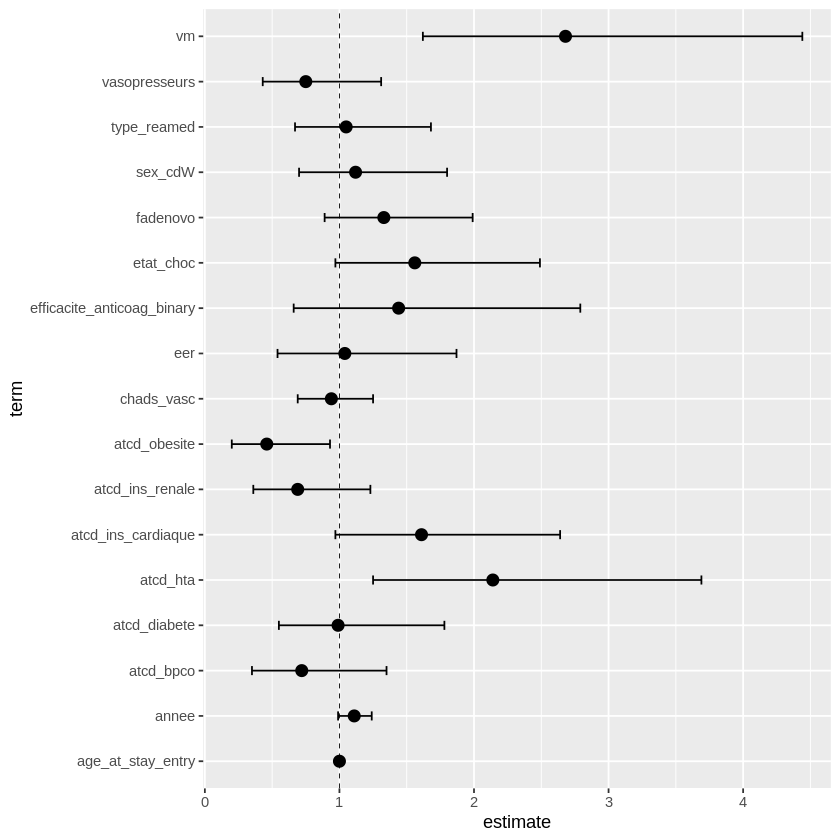

In [66]:
mv_ischemie_traitement %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

#### Sans la variable de l'efficacité du traitement

In [67]:
mv_ischemie <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo,
              data=collect(sejours_rea_48_heures), family="binomial") %>%
              broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
              mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_ischemie

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,115.69,-1.86,0.06,0.00,1184.17
volonte_anticoag,1.08,0.22,0.36,0.72,0.69,1.66
sex_cdW,1.13,0.24,0.51,0.61,0.70,1.81
age_at_stay_entry,1.00,0.01,0.19,0.85,0.98,1.02
vasopresseurs,0.75,0.29,-1.01,0.31,0.43,1.31
eer,1.02,0.32,0.07,0.94,0.53,1.85
chads_vasc,0.94,0.15,-0.41,0.68,0.69,1.25
vm,2.67,0.26,3.80,0.00,1.60,4.42
atcd_hta,2.13,0.28,2.74,0.01,1.25,3.69


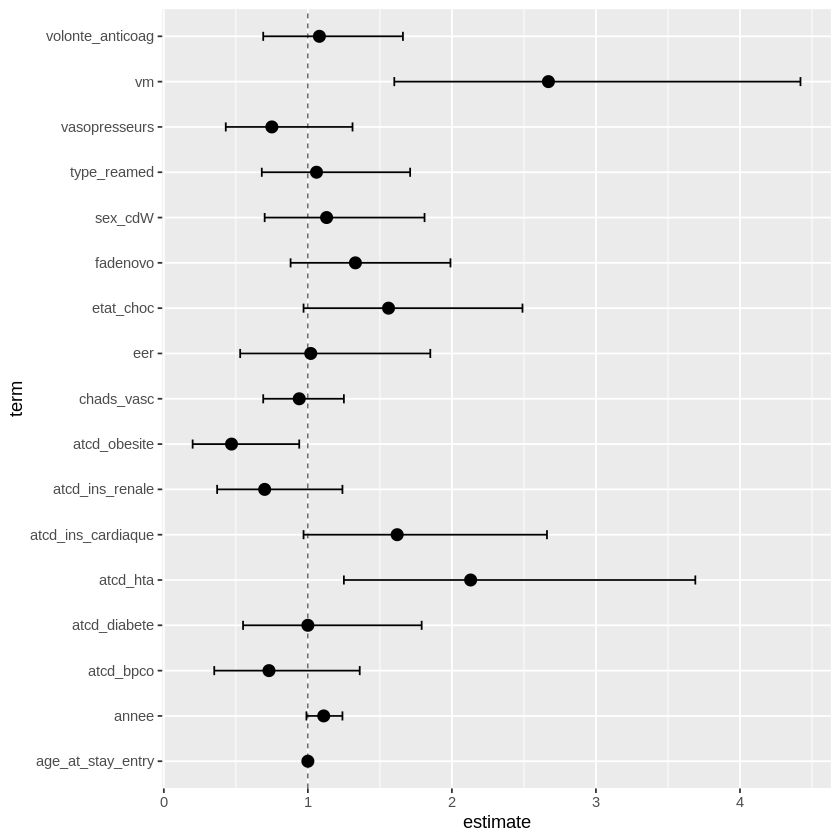

In [68]:
mv_ischemie %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

In [69]:
#### Modèle multivarié sans la variable d'efficacité ni celle de la volonté d'anticoagulation
mv_ischemie_mathilde <- glm(ischemie_cerebrale ~ sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo + coagulopathie,
              data=collect(sejours_rea_48_heures), family="binomial") %>%
              broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
              mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_ischemie_mathilde

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,115.44,-1.88,0.06,0.00,90.11
sex_cdW,1.13,0.24,0.52,0.60,0.70,1.82
age_at_stay_entry,1.00,0.01,0.19,0.85,0.98,1.02
vasopresseurs,0.75,0.29,-1.02,0.31,0.43,1.31
eer,1.01,0.32,0.03,0.98,0.52,1.83
chads_vasc,0.94,0.15,-0.42,0.67,0.69,1.25
vm,2.68,0.26,3.81,0.00,1.61,4.43
atcd_hta,2.14,0.28,2.75,0.01,1.25,3.69
atcd_bpco,0.74,0.34,-0.90,0.37,0.35,1.37


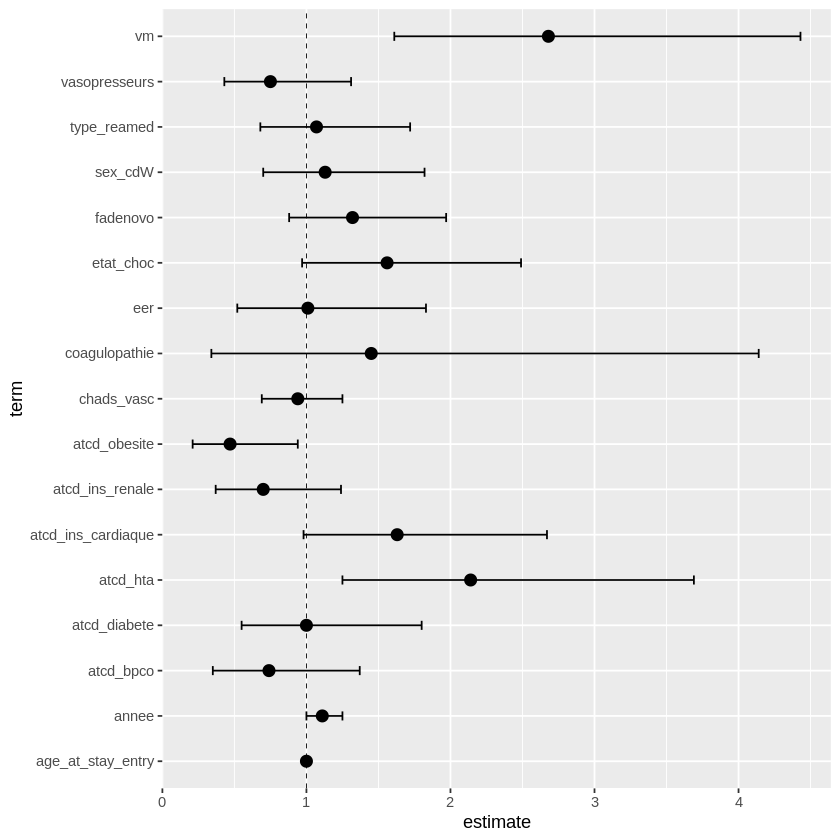

In [70]:
mv_ischemie_mathilde %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

### Complications hémorragiques

In [71]:
sejours_rea_48_heures %>%
    group_by(volonte_anticoag) %>%
    summarise(
        nb_sejours = n(),
        nb_hemorragie = sum(hemorragie)
    ) %>%
    mutate(pct_hemorragie = round(nb_hemorragie / nb_sejours * 100, 1)) %>%
    as_tibble()

volonte_anticoag,nb_sejours,nb_hemorragie,pct_hemorragie
<dbl>,<int>,<dbl>,<dbl>
0,3678,292,7.9
1,1284,110,8.6


In [72]:
sejours_rea_48_heures %>%
    group_by(volonte_anticoag) %>%
    summarise(
        nb_sejours = n(),
        nb_hemorragie_iatrogene = sum(hemorragie_iatrogene)
    ) %>%
    mutate(pct_hemorragie_iatrogene = round(nb_hemorragie_iatrogene / nb_sejours * 100, 1)) %>%
    as_tibble()

volonte_anticoag,nb_sejours,nb_hemorragie_iatrogene,pct_hemorragie_iatrogene
<dbl>,<int>,<dbl>,<dbl>
0,3678,96,2.6
1,1284,58,4.5


In [73]:
sejours_rea_48_heures %>%
    group_by(volonte_anticoag, type_rea) %>%
    summarise(
        nb_sejours = n(),
        nb_hemorragie_iatrogene = sum(hemorragie_iatrogene)
    ) %>%
    mutate(pct_hemorragie_iatrogene = round(nb_hemorragie_iatrogene / nb_sejours * 100, 1)) %>%
    as_tibble()

`summarise()` has grouped output by 'volonte_anticoag'. You can override using
the `.groups` argument.


volonte_anticoag,type_rea,nb_sejours,nb_hemorragie_iatrogene,pct_hemorragie_iatrogene
<dbl>,<chr>,<int>,<dbl>,<dbl>
0,chir,980,50,5.1
0,med,2698,46,1.7
1,chir,280,32,11.4
1,med,1004,26,2.6


In [74]:
mv_hemorragie <- glm(hemorragie ~ sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + coagulopathie + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc,
              data=collect(sejours_rea_48_heures),  family="quasibinomial", weights = sejours_rea_48_heures$weights) %>%
              broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
              mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_hemorragie

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,63.13,-2.25,0.02,0.00,0.00
sex_cdW,0.94,0.13,-0.45,0.65,0.73,1.22
age_at_stay_entry,0.99,0.01,-2.14,0.03,0.98,1.00
vasopresseurs,0.68,0.15,-2.58,0.01,0.50,0.91
eer,0.86,0.17,-0.84,0.40,0.61,1.21
chads_vasc,1.08,0.08,0.94,0.35,0.92,1.25
coagulopathie,1.71,0.35,1.54,0.12,0.82,3.28
vm,1.90,0.14,4.62,0.00,1.44,2.49
atcd_hta,1.23,0.14,1.43,0.15,0.93,1.63


In [75]:
mv_hemorragie_volonte <- glm(hemorragie ~ volonte_anticoag + surdosage + sex_cd + age_at_stay_entry + coagulopathie + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc,
                             data=collect(sejours_rea_48_heures), family="quasibinomial", weights = sejours_rea_48_heures$weights) %>%
                            broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
                            mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_hemorragie_volonte

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,62.97,-2.37,0.02,0.00,0.00
volonte_anticoag,1.08,0.11,0.69,0.49,0.87,1.34
surdosage,0.65,0.18,-2.42,0.02,0.45,0.91
sex_cdW,0.96,0.13,-0.34,0.74,0.74,1.23
age_at_stay_entry,0.99,0.01,-2.16,0.03,0.98,1.00
coagulopathie,1.72,0.35,1.56,0.12,0.83,3.30
vasopresseurs,0.68,0.15,-2.58,0.01,0.50,0.91
eer,0.87,0.17,-0.80,0.42,0.61,1.21
chads_vasc,1.08,0.08,1.02,0.31,0.93,1.26


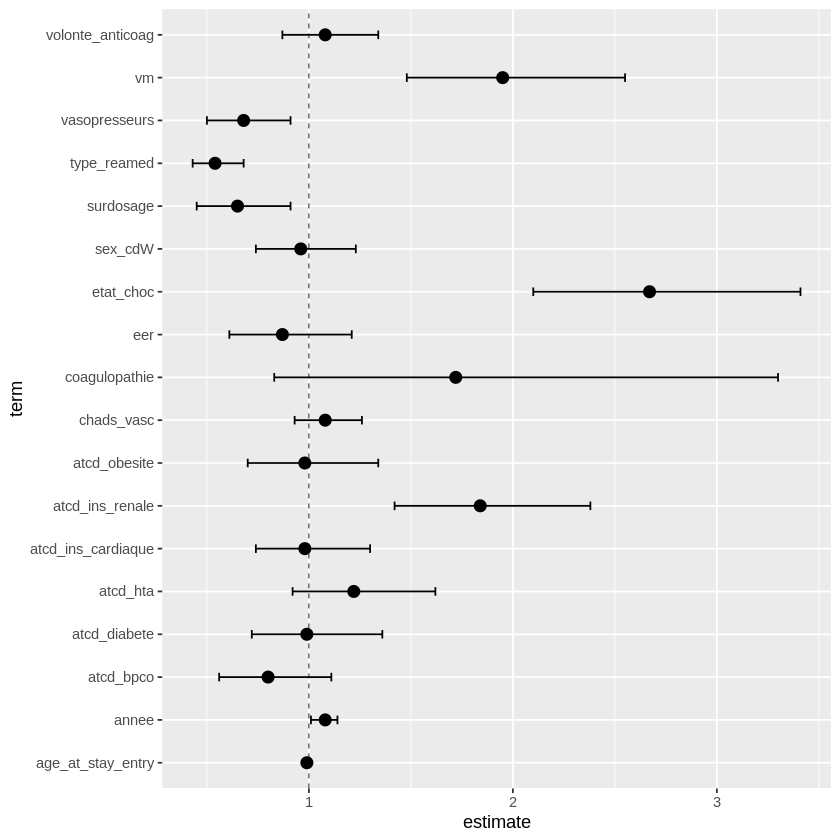

In [76]:
mv_hemorragie_volonte %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

In [77]:
mv_hemorragie_iatrogene_volonte <- glm(hemorragie_iatrogene ~ volonte_anticoag + surdosage + sex_cd + age_at_stay_entry + coagulopathie + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc,
              data=collect(sejours_rea_48_heures), family="quasibinomial", weights = sejours_rea_48_heures$weights) %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_hemorragie_iatrogene_volonte

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,103.85,-2.81,0.00,0.00,0.00
volonte_anticoag,2.14,0.17,4.56,0.00,1.55,2.98
surdosage,0.66,0.24,-1.75,0.08,0.40,1.03
sex_cdW,1.20,0.18,1.00,0.32,0.84,1.73
age_at_stay_entry,0.99,0.01,-1.26,0.21,0.97,1.01
coagulopathie,2.46,0.51,1.77,0.08,0.81,6.14
vasopresseurs,0.62,0.22,-2.20,0.03,0.40,0.94
eer,0.56,0.31,-1.87,0.06,0.30,1.00
chads_vasc,1.23,0.11,1.90,0.06,0.99,1.52


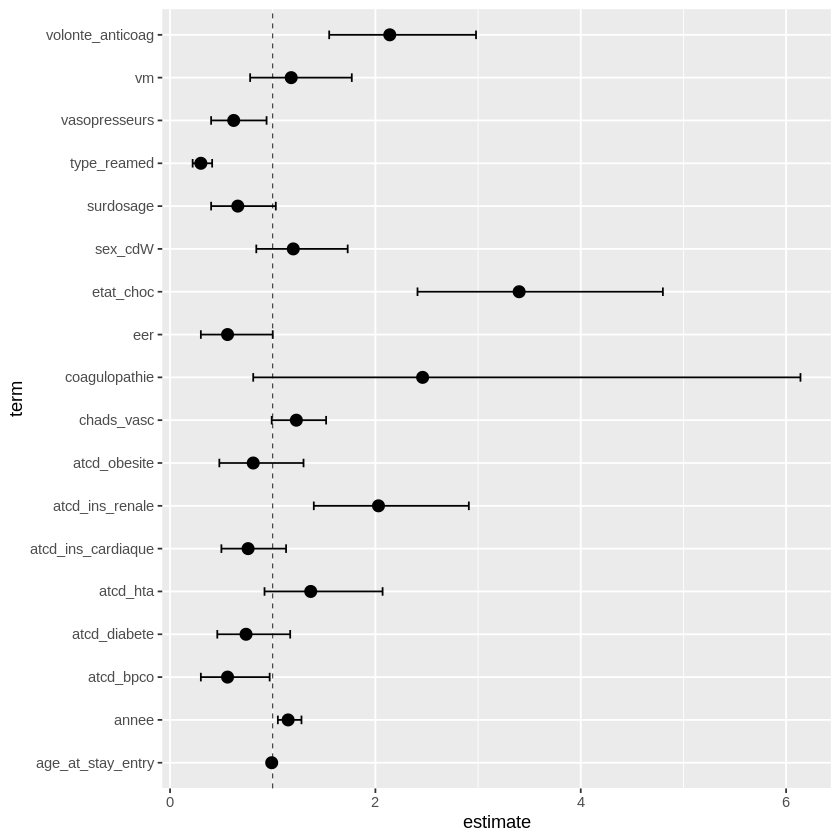

In [78]:
mv_hemorragie_iatrogene_volonte %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

In [79]:
mv_hemorragie_cerebrale_volonte <- glm(hemorragie_cerebrale ~ volonte_anticoag + surdosage + sex_cd + age_at_stay_entry + coagulopathie + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc,
              data=collect(sejours_rea_48_heures), family="quasibinomial", weights = sejours_rea_48_heures$weights) %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_hemorragie_cerebrale_volonte

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.614418e+35,181.99,0.45,0.65,0.00,1.881569e+187
volonte_anticoag,4.900000e-01,0.39,-1.84,0.07,0.22,1.020000e+00
surdosage,5.800000e-01,0.72,-0.76,0.44,0.11,2.020000e+00
sex_cdW,1.370000e+00,0.44,0.72,0.47,0.58,3.260000e+00
age_at_stay_entry,1.010000e+00,0.02,0.61,0.54,0.98,1.050000e+00
coagulopathie,1.490000e+00,1.04,0.39,0.70,0.09,7.790000e+00
vasopresseurs,4.600000e-01,0.46,-1.72,0.09,0.19,1.120000e+00
eer,9.700000e-01,0.56,-0.05,0.96,0.28,2.680000e+00
chads_vasc,7.100000e-01,0.29,-1.21,0.23,0.39,1.200000e+00


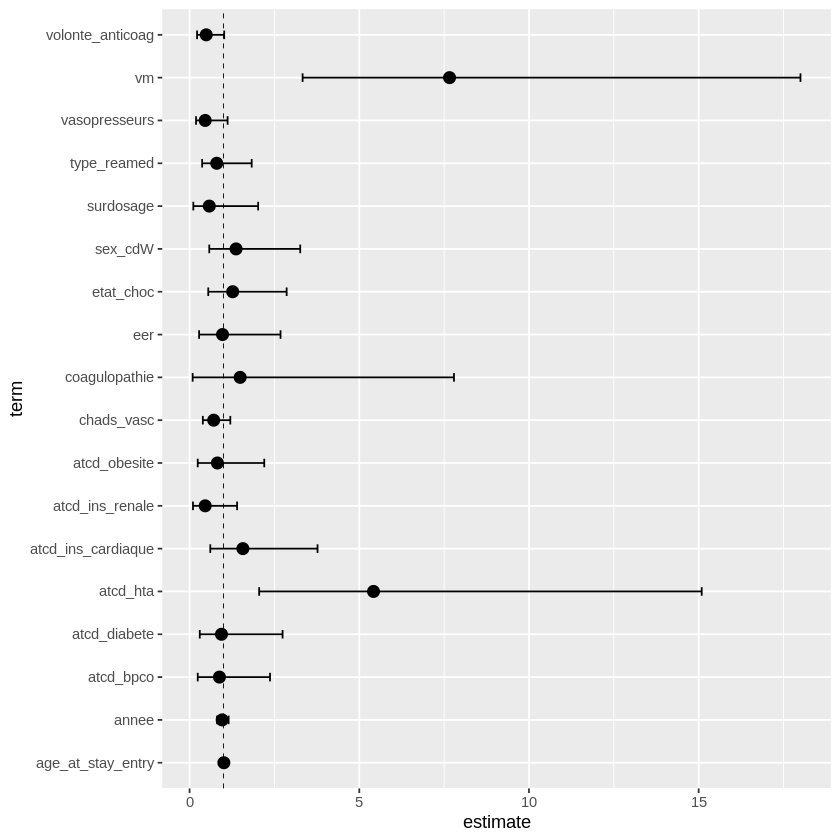

In [80]:
mv_hemorragie_cerebrale_volonte %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

### Mortalité

In [81]:
mv_mortalite <- glm(death_during_stay~efficacite_anticoag_binary + age_at_stay_entry + vasopresseurs + eer + 
                               coagulopathie + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                               atcd_ins_cardiaque + atcd_ins_renale + etat_choc + hemorragie + ischemie_cerebrale + type_rea,
                    data=collect(sejours_rea_48_heures), family="binomial") %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_mortalite

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,0.41,-14.03,0.00,0.00,0.01
efficacite_anticoag_binary,1.56,0.18,2.46,0.01,1.08,2.21
age_at_stay_entry,1.03,0.01,6.21,0.00,1.02,1.05
vasopresseurs,1.32,0.14,2.01,0.04,1.01,1.74
eer,2.27,0.13,6.23,0.00,1.75,2.93
coagulopathie,1.90,0.28,2.30,0.02,1.09,3.25
chads_vasc,1.03,0.07,0.39,0.69,0.90,1.17
vm,3.31,0.13,9.28,0.00,2.57,4.26
atcd_hta,0.61,0.14,-3.55,0.00,0.47,0.80


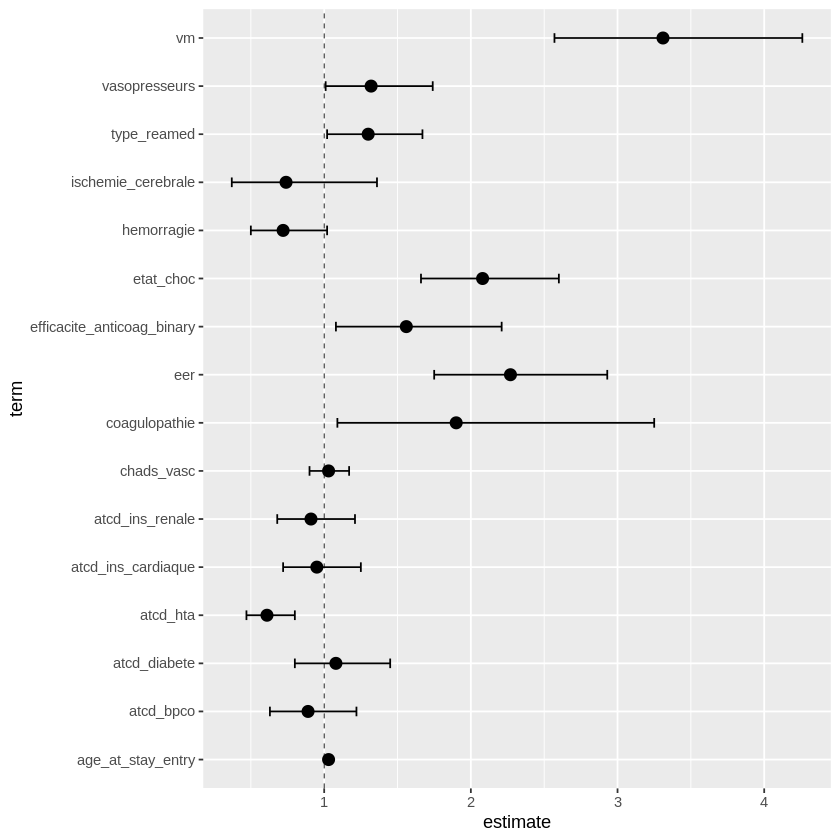

In [82]:
mv_mortalite %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

## Analyses de sous-groupes
### FA de novo

In [83]:
mv_ischemie_fadenovo <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc,
              data=collect(sejours_rea_48_heures %>% filter (fadenovo == 1)), family="binomial") %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_ischemie_fadenovo

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.693562e+80,166.19,1.11,0.27,0.00,3.379991e+218
volonte_anticoag,1.140000e+00,0.36,0.36,0.72,0.54,2.240000e+00
sex_cdW,1.010000e+00,0.36,0.03,0.98,0.49,2.050000e+00
age_at_stay_entry,9.900000e-01,0.02,-0.67,0.50,0.96,1.020000e+00
vasopresseurs,3.900000e-01,0.46,-2.05,0.04,0.16,9.600000e-01
eer,1.180000e+00,0.49,0.34,0.73,0.42,2.890000e+00
chads_vasc,1.050000e+00,0.22,0.24,0.81,0.68,1.580000e+00
vm,3.670000e+00,0.39,3.37,0.00,1.71,7.790000e+00
atcd_hta,1.910000e+00,0.41,1.57,0.12,0.86,4.350000e+00


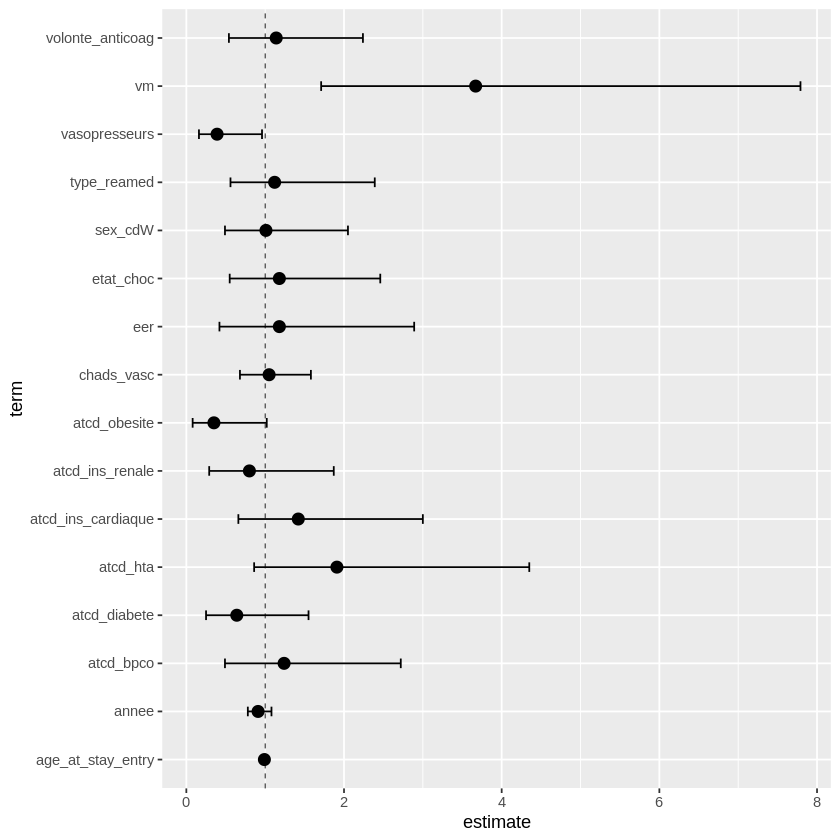

In [84]:
mv_ischemie_fadenovo %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

### Choc septique

In [85]:
mv_ischemie_choc_septique <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + fadenovo,
              data=collect(sejours_rea_48_heures %>% filter (choc_septique == 1)), family="binomial") %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_ischemie_choc_septique

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,268.35,-0.19,0.85,0.00,5.263956e+200
volonte_anticoag,0.97,0.45,-0.08,0.94,0.38,2.270000e+00
sex_cdW,0.40,0.60,-1.53,0.13,0.11,1.200000e+00
age_at_stay_entry,1.00,0.02,0.06,0.96,0.96,1.050000e+00
vasopresseurs,0.50,0.62,-1.13,0.26,0.15,1.710000e+00
eer,1.87,0.47,1.33,0.18,0.72,4.640000e+00
chads_vasc,0.87,0.30,-0.46,0.64,0.47,1.530000e+00
vm,2.41,0.60,1.47,0.14,0.78,8.240000e+00
atcd_hta,1.50,0.55,0.74,0.46,0.51,4.510000e+00


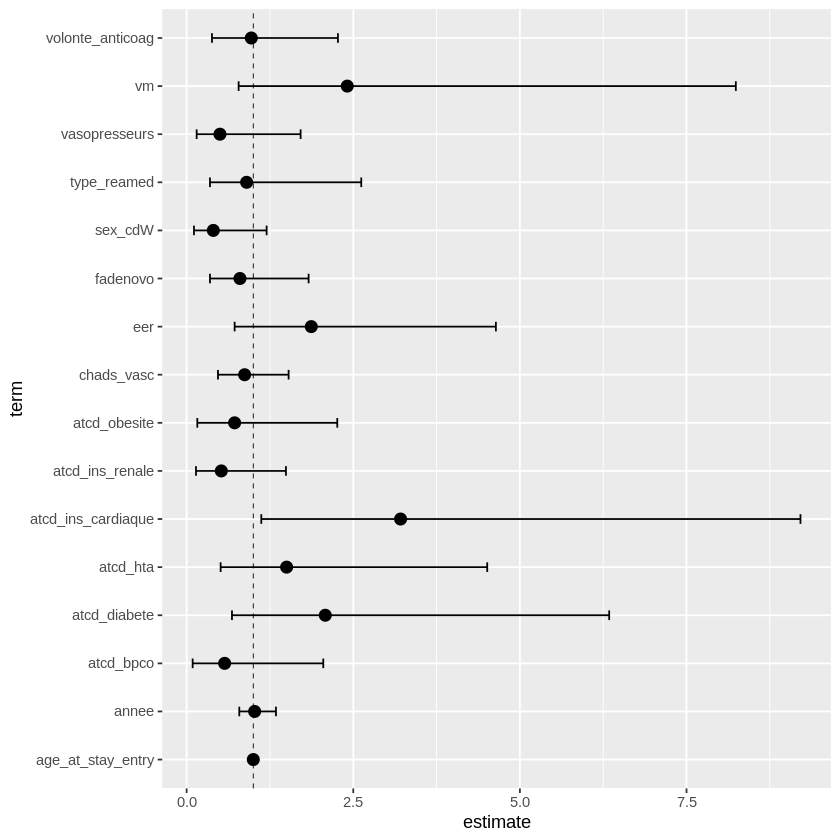

In [86]:
mv_ischemie_choc_septique %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), linewidth = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), linewidth = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

### CHA2DS2-VASC > 3

In [87]:
mv_ischemie_chads_3 <- glm(ischemie_cerebrale ~ volonte_anticoag + sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo,
              data=collect(sejours_rea_48_heures %>% filter (chads_vasc > 3)), family="binomial") %>%
    broom::tidy(exponentiate = TRUE, conf.int = TRUE) %>%
    mutate(across(where(is.numeric), .fns = ~round(., digits = 2)))

mv_ischemie_chads_3

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.065331e+145,272.82,1.22,0.22,0.00,Inf
volonte_anticoag,6.500000e-01,0.54,-0.80,0.42,0.20,1.76
sex_cdW,3.400000e-01,0.52,-2.06,0.04,0.12,0.91
age_at_stay_entry,9.700000e-01,0.03,-1.02,0.31,0.92,1.03
vasopresseurs,4.400000e-01,0.67,-1.24,0.22,0.11,1.58
eer,6.900000e-01,0.83,-0.45,0.65,0.10,2.98
chads_vasc,1.520000e+00,0.31,1.36,0.17,0.80,2.73
vm,2.580000e+00,0.60,1.58,0.12,0.78,8.30
atcd_hta,2.370000e+00,1.07,0.81,0.42,0.43,44.61


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


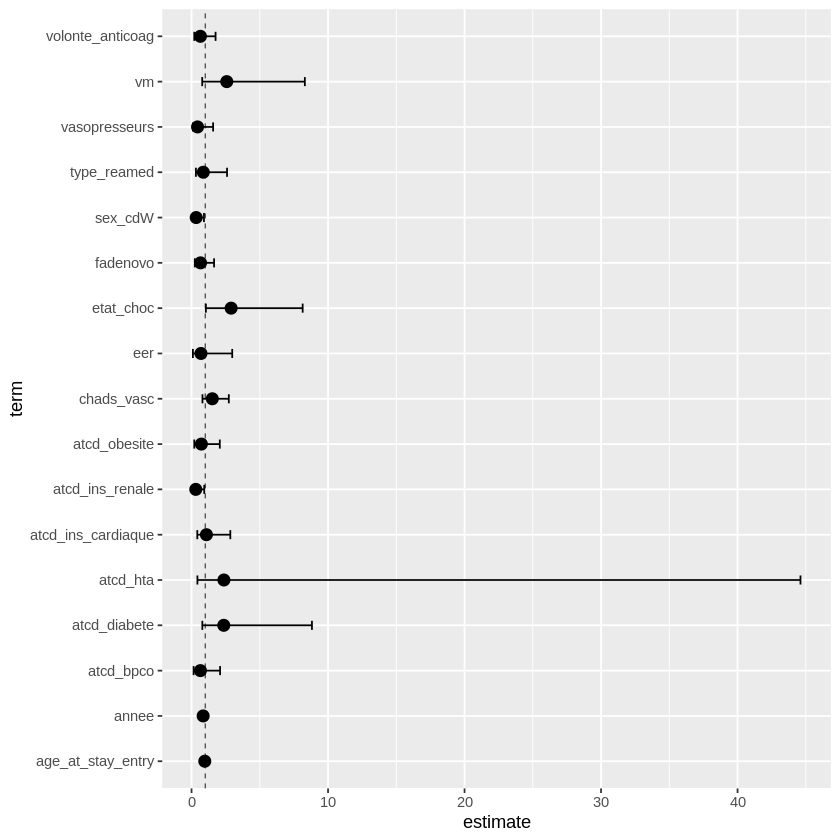

In [88]:
mv_ischemie_chads_3 %>%
    slice(-1) %>%
    ggplot + aes(x = estimate, y = term) +
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), size = .5, height = .2, ) +
    geom_point(size = 3, color = "black")

### Graphique des OR/RR global et en fonction des sous-groupes

In [89]:
mv_ischemie_traitement

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,115.79,-1.84,0.07,0.00,13010.47
efficacite_anticoag_binary,1.44,0.36,1.01,0.31,0.66,2.79
sex_cdW,1.12,0.24,0.48,0.63,0.70,1.80
age_at_stay_entry,1.00,0.01,0.18,0.85,0.98,1.02
vasopresseurs,0.75,0.29,-1.01,0.31,0.43,1.31
eer,1.04,0.32,0.11,0.91,0.54,1.87
chads_vasc,0.94,0.15,-0.43,0.67,0.69,1.25
vm,2.68,0.26,3.83,0.00,1.62,4.44
atcd_hta,2.14,0.28,2.75,0.01,1.25,3.69


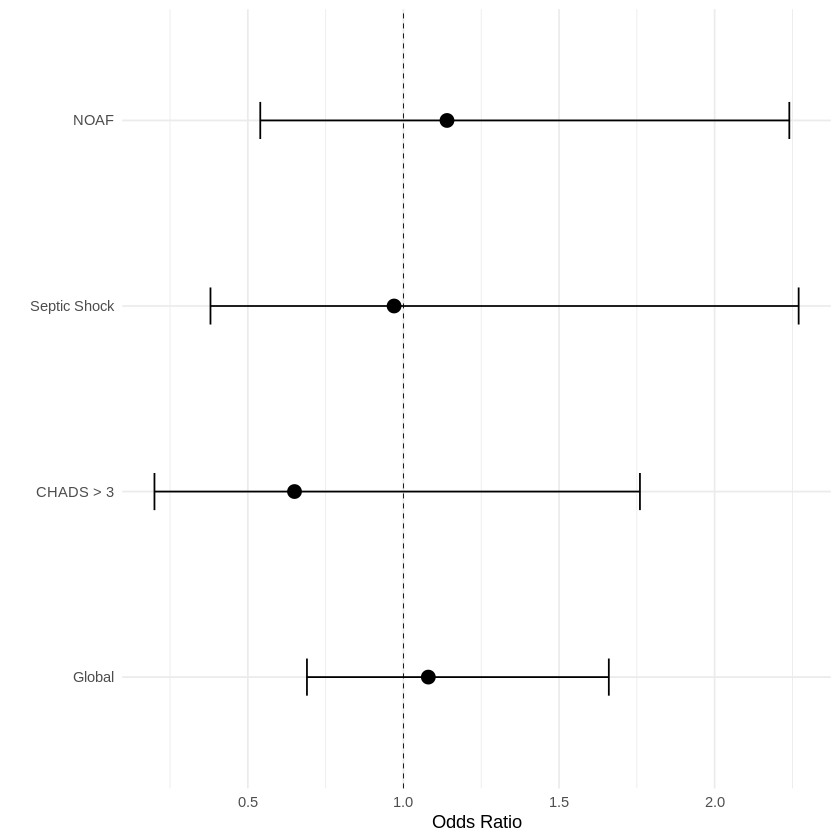

In [90]:
bind_rows(lst(mv_ischemie, mv_ischemie_chads_3, mv_ischemie_choc_septique, mv_ischemie_fadenovo), .id = "id") %>%
    filter(term == 'volonte_anticoag') %>%
    mutate(id = case_when(
        id == "mv_ischemie" ~ "Global",
        id == "mv_ischemie_chads_3" ~ "CHADS > 3",
        id == "mv_ischemie_choc_septique" ~ "Septic Shock",
        id == "mv_ischemie_fadenovo" ~ "NOAF"
        )) %>%
    ggplot + aes(x = estimate, y = fct_relevel(id, "Global", "CHADS > 3", "Septic Shock", "NOAF")) +
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), size = .5, height = .2) +
    geom_point(size = 3.5, color = "black") +
    labs(x = "Odds Ratio",
         y = "") +
    theme_minimal()

## Analyses de sensibilité supplémentaires
### Calcul de l'ATE dans le sous-groupe des patients ayant une FA de novo

In [91]:
sejours_rea_48_heures_fa_de_novo <- sejours_rea_48_heures %>% filter (fadenovo == 1)

fit <- glm(ischemie_cerebrale ~ volonte_anticoag * (sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo), 
           data = collect(sejours_rea_48_heures_fa_de_novo), family = 'quasibinomial', weights = sejours_rea_48_heures_fa_de_novo$weights)

In [92]:
avg_comparisons(fit, variables = "volonte_anticoag",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures_fa_de_novo),
                wts = sejours_rea_48_heures_fa_de_novo$weights,
                comparison = "lnratioavg",
                transform = "exp")

term,contrast,estimate,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
volonte_anticoag,ln(mean(1) / mean(0)),1.476111,0.3668531,1.446726,0.6335707,3.439084,0.007389277,0.2590646,0.007389277


In [93]:
avg_comparisons(fit, variables = "volonte_anticoag",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures_fa_de_novo),
                wts = sejours_rea_48_heures_fa_de_novo$weights)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
volonte_anticoag,1 - 0,0.01418877,0.01808065,0.7847487,0.4326009,1.208891,-0.02124866,0.0496262


### Calcul de l'ATE dans le sous-groupe des patients ayant une anticoagulation jugée efficace

In [94]:
fit <- glm(ischemie_cerebrale ~ efficacite_anticoag_binary * (sex_cd + age_at_stay_entry + vasopresseurs + eer + chads_vasc + vm + atcd_hta + atcd_bpco + atcd_diabete + 
                                                    atcd_ins_cardiaque + atcd_ins_renale + atcd_obesite + annee + type_rea + etat_choc + fadenovo), 
           data = collect(sejours_rea_48_heures), family = 'quasibinomial', weights = sejours_rea_48_heures$weights)

In [95]:
avg_comparisons(fit, variables = "efficacite_anticoag_binary",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures),
                wts = sejours_rea_48_heures$weights,
                comparison = "lnratioavg",
                transform = "exp")

term,contrast,estimate,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
efficacite_anticoag_binary,ln(mean(1) / mean(0)),1.234161,0.6619416,0.5952241,0.4806005,3.169273,0.02195909,0.004459326,0.02195909


In [96]:
avg_comparisons(fit, variables = "efficacite_anticoag_binary",
                vcov = "HC3",
                newdata = collect(sejours_rea_48_heures),
                wts = sejours_rea_48_heures$weights)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
efficacite_anticoag_binary,1 - 0,0.004970271,0.01243159,0.3998099,0.6892966,0.5368033,-0.01939519,0.02933573
